In [1]:
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from torch_geometric.data import Data, DataLoader, DenseDataLoader as DenseLoader
from torch_geometric.data import InMemoryDataset
import torch_geometric.transforms as T

from diff_pool6_avg import DiffPool as DiffPool


In [2]:
# load data
with open(r'./data/patient_gumbel3.pickle', 'rb') as handle:
        patient_dict= pickle.load(handle)
        
class PatientDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(PatientDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['patient.dataset']

    def download(self):
        pass
    
    def process(self):
        
        data_list = []
        node_labels_dict = {'CD3p': 0, 'CD3p_CD4p': 1, 'CD8p_CD3p': 2, 'Tumorp': 3, 'Stromap': 4}
        class_num = len(node_labels_dict)
        
        for idx, v in enumerate(patient_dict.values()):
            for G in v:
                node_features = torch.LongTensor([node_labels_dict[i] for i in 
                                list(nx.get_node_attributes(G, 'cell_types').values())]).unsqueeze(1)
                x = torch.zeros(len(G.nodes), class_num).scatter_(1, node_features, 1)
                y = torch.LongTensor([idx])
                edges = sorted([e for e in G.edges] + [e[::-1] for e in G.edges])
                edge_index = torch.tensor([[e[0] for e in edges],
                                           [e[1] for e in edges]], dtype=torch.long)
                data = Data(x=x, edge_index=edge_index, y=y)
                data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        
def get_dataset(path, sparse=False):
    
    dataset = PatientDataset(path)
    if not sparse:
        max_num_nodes = 0
        for data in dataset:
            max_num_nodes = max(data.num_nodes, max_num_nodes)

        if dataset.transform is None:
            dataset.transform = T.ToDense(max_num_nodes)
        else:
            dataset.transform = T.Compose(
                [dataset.transform, T.ToDense(max_num_nodes)])

    return dataset

path = './data/patient_gumbel3'
dataset = get_dataset(path, sparse=False)


In [3]:
# save on gpu, load on cpu
# load model parameters 
def load_model(dir_path, params_name, m, num_patches=5, ratio=0.05, plot=True, ge=False):
    device = torch.device('cpu')
    model = m(dataset, 5, 64, num_patches=num_patches, ratio=ratio, plot=plot, ge=ge)
    params = torch.load(dir_path+params_name, map_location=device)
    model.load_state_dict(params)
    return model


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def cal_cfm_LogSoftmax(model, loader, num_patches=5):
    model.eval()
    matrix = []
    y_true = []
    y_pred = []
    
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out, _ = model(data)
            matrix.append(out.numpy())
            pred = out.max(1)[1]
            y_pred += pred.tolist()
            len_ = len(data.y)
            indices = [i for i in range(0, len_, num_patches)]
            y_true += data.y[indices].view(-1).tolist()
            
    matrix = np.concatenate(matrix)
    return confusion_matrix(y_true, y_pred), matrix


def plot_cfm_LogSoftmax(cfm, matrix, title):
    sns.set(font_scale=1.3)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
    plt.suptitle(title, fontsize=14)
    
    df_cm = pd.DataFrame(cfm, range(1, cfm.shape[0]+1), range(1, cfm.shape[0]+1))
    sns.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, annot_kws={"size": 16}, ax=ax1)
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('True label')
    ax1.set_title('confusion matrix')
    
    ax2.imshow(matrix, cmap=cm.Blues, extent=[0.5, 10.5, 10.5, 0.5])
    ax2.set_xticks([i for i in range(1, 11)])
    ax2.set_yticks([i for i in range(1, 11)])
    ax2.set_xlabel('Predicted label')
    ax2.set_ylabel('True label')
    ax2.set_title('softmax values')
    
    plt.show()
    
def plot_loss_acc(filename):
    with open(filename) as f:
        contents = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    dic = {}
    for line in contents:
        if "Num" in line:
            param = line.strip()
            dic[param] = [[], []]
        if "Train Loss" in line:
            loss = float(re.findall("Train Loss: ([0-9.]+)", line)[0])
            acc = float(re.findall("Train Accuracy: ([0-9.]+)", line)[0])
            dic[param][0].append(loss)
            dic[param][1].append(acc)
    
    for key, val in dic.items():
        fig, (ax_loss, ax_acc) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 12))
        ax_loss.set_title("Loss")
        length = len(val[0])
        # plot mean loss
        ax_loss.plot(range(1, length+1), val[0])

        ax_acc.set_title("Accuracy")
        length = len(val[1])
        ax_acc.plot(range(1, length+1), val[1])

## Freeze

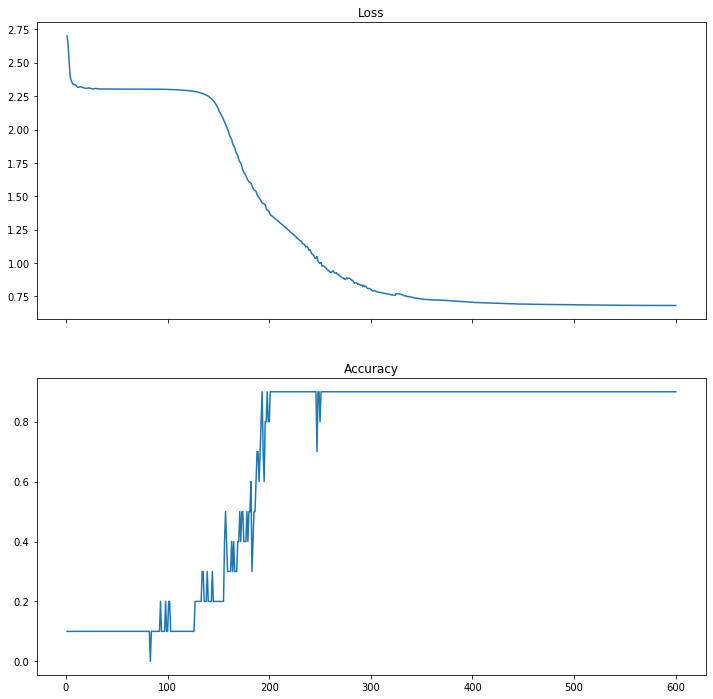

In [4]:
dir_path = './data/DiffPool_diff_pool6_avg_bs50/gumbel1_5/'
plot_loss_acc(dir_path+'log_2020-10-30_07-40.txt')


In [5]:
batch_size = 50
num_patches = 5
data_loader = DenseLoader(dataset, batch_size, shuffle=False)

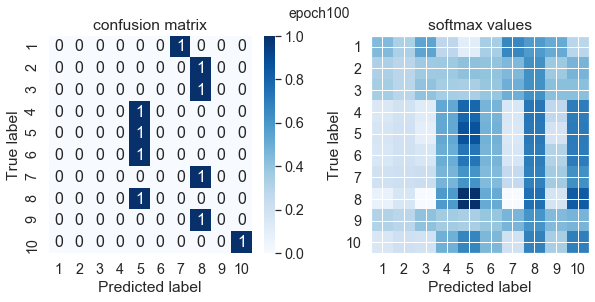

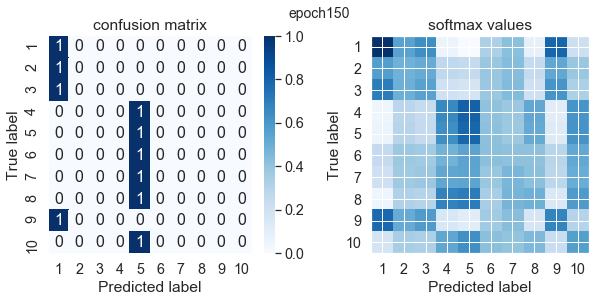

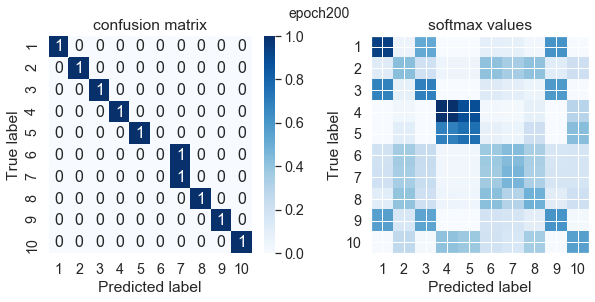

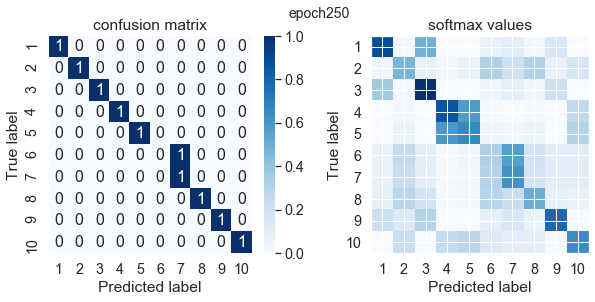

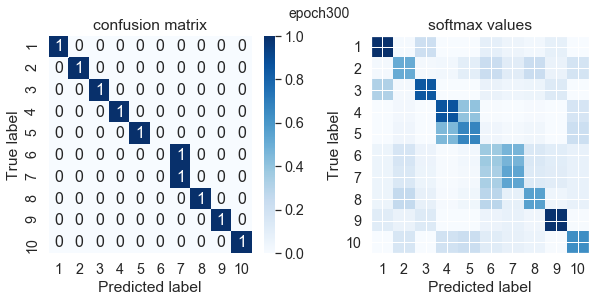

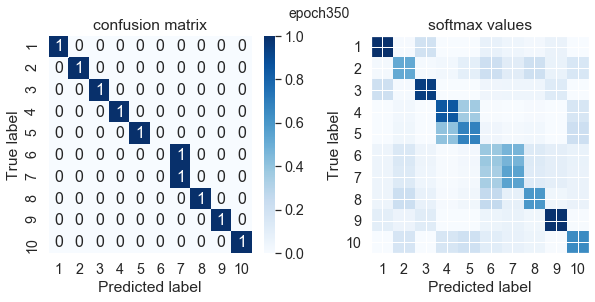

In [8]:
dir_path = './data/DiffPool_diff_pool6_avg_bs50/gumbel1_5/'
for epoch in [100, 150, 200, 250, 300, 350]:
    params_name = 'params_epoch{}.pt'.format(epoch)
    model = load_model(dir_path, params_name, DiffPool, \
                       num_patches=num_patches, ratio=0.05)
    cfm, matrix = cal_cfm_LogSoftmax(model, data_loader, num_patches=num_patches)
    plot_cfm_LogSoftmax(cfm, matrix, 'epoch{}'.format(epoch))